In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input/trafficsigns'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior() 

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ***Preprocessing***

In [32]:
# 43 different classes(traffic signs)
# The size of the images after being resized
n_classes = 43 
resized_image = (32, 32)

In [33]:
# Read the images, convert them to grayscale 
# resize them to a predefined shape
# and also one-hot encode the label

Dataset= namedtuple('Dataset', ['X', 'y'])
def to_tf_format(imgs):
    return np.stack([img[:,:, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset(rootpath, n_labels, resize_to):
    images = []
    labels = []
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        for img_name in glob.glob(full_path + '*.ppm'):
            img = plt.imread(img_name)
            img = rgb2lab(img)[:, :, 0] 
            img = resize(img, resize_to, mode = 'reflect')
            label = np.zeros((n_labels), dtype=np.float32)
            label[c] = 1.0
            images.append(img.astype(np.float32))
            labels.append(label)

            return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

#Run the function 
dataset = read_dataset('D:/Projects/Traffic-signs/data/GTSRB/Images', n_classes, resized_image)
print(dataset.X.shape)
print(dataset.y.shape) 

(39209, 32, 32, 1)
(39209, 43)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


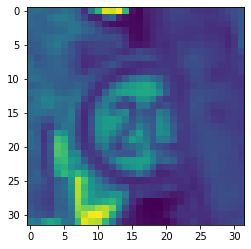

In [34]:
# Observe the first image in our dataset
# together with its label
plt.imshow(dataset.X[0,:,:,:].reshape(resized_image))
print(dataset.y[0])

In [35]:
# Split the dataset into training data(75%) and test data(25%)

from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=10)
Xtrain = dataset.X[idx_train,...]
Xtest = dataset.X[idx_test,...]
ytrain = dataset.y[idx_train,...]
ytest = dataset.y[idx_test,...]
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(29406, 32, 32, 1)
(9803, 32, 32, 1)
(29406, 43)
(9803, 43)


# ***Train the model and make predictions***

In [36]:
# minibatcher function gerenates minibatches of training data
# at each training iteration, a minibatch of samples 
# is inserted into the model 
def minibatcher(x, y, batch_size, shuffle):
    assert x.shape[0] == y.shape[0]
    n_samples = x.shape[0]
    if shuffle:
        idx = np.random.permutation (n_samples)
    else:
        idx = list(range(n_samples))
    for k in range (int(np.ceil(n_samples/batch_size))):
        from_idx = k*batch_size
        to_idx = (k+1)*batch_size
        yield x[idx[from_idx:to_idx],...], y[idx[from_idx:to_idx],...] 

batch_size = 10000
for mb in minibatcher(Xtrain, ytrain, batch_size, True):
    print(mb[0].shape, mb[1].shape)
        
    
    

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


In [37]:
#Build the blocks that will compose the network

import tensorflow as tf

# fc_no_activation_layer represents a fully 
# connected layer without an activation function
# with 'w' denotes the weights and 'b' the bias

def fc_no_activation_layer(in_tensors, n_units):
    with tf1.variable_scope('fc_layer', reuse = tf1.AUTO_REUSE):
        w = tf1.get_variable('fc_W', [in_tensors.get_shape()[1], n_units],
                        tf.float32, tf.keras.initializers.GlorotUniform())
        b = tf1.get_variable('fc_B', [n_units,], tf.float32,
                        tf.constant_initializer(0.0))
    return tf.matmul(in_tensors, w) + b

# A fully connected layer with leaky ReLU
# as an activation function
def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

# A convolutional layer with the activation
# function leaky ReLU
def conv_layer(in_tensors, kernel_size, n_units):
    with tf1.variable_scope('c_layer', reuse = tf1.AUTO_REUSE):
        w = tf1.get_variable('conv_W', [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
                        tf.float32, tf.keras.initializers.GlorotUniform())
        b = tf1.get_variable('conv_B', [n_units,], tf.float32,
                        tf.constant_initializer(0.0))
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w , [1, 1, 1, 1], 'SAME') + b)

# A Maxpooling layer
def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')

# A dropout layer for regularizing the network
def dropout(in_tensors, keep_prob, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_prob), lambda: in_tensors)

    

In [38]:
# Create the model
def model(in_tensors, is_training):
    # First layer: 5x5 2d-conv, 32 filters, 2x maxpool, 20% dropout
    with tf1.variable_scope('l1_scope', reuse=tf1.AUTO_REUSE):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
        # Second layer: 5x5 2d-conv, 64 filters, 2x maxpool, 20% dropout
    with tf1.variable_scope('l2_scope', reuse=tf1.AUTO_REUSE):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
    with tf1.variable_scope('flatten', reuse=tf1.AUTO_REUSE):
        l2_out_flat = tf1.layers.flatten(l2_out)
    # Fully connected layer, 1024 neurons, 40% dropout
    with tf1.variable_scope('l3_scope', reuse=tf1.AUTO_REUSE):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
    # Output
    with tf1.variable_scope('out', reuse=tf1.AUTO_REUSE):
        out_tensors = fc_no_activation_layer(l3_out, n_classes)
    return out_tensors
    
        

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

# Train the model on the training set
# and test the performance on the test set
def train_model(X_train, y_train, X_test, y_test, batch_size, learning_rate, max_epochs):
    
    # Define 3 Tensorfow placeholders;
    # one for the minibatch of images
    # one for the minibatch of labels
    # and the last one to select whether to run for training or not
    in_X_tensors_batch = tf1.placeholder(tf.float32, shape = (None,resized_image[0], resized_image[1], 1 ))
    in_y_tensors_batch = tf1.placeholder(tf.float32, shape = (None,n_classes))
    is_training = tf1.placeholder(tf.bool)
    
    #Define the output, metric score, and optimizer   
    logits = model(in_X_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf1.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf1.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Train the model with minibatches
    with tf1.Session() as session:
        session.run(tf1.global_variables_initializer())
        for epoch in range(max_epochs):
            print('Epochs=', epoch)
            tf_score = []
            for mb in minibatcher(X_train, y_train, batch_size, shuffle = True):
                tf_output = session.run([optimizer, loss], feed_dict = {in_X_tensors_batch : mb[0],
                                                                        in_y_tensors_batch : mb[1], 
                                                                        is_training : True})
                tf_score.append(tf_output[1])
            print('train_loss_score=', np.mean(tf_score))
        
        #Test the model on the test set
        # Test on the whole test set
        print('TEST SET PERFORMANCE')
        y_test_pred, test_loss = session.run([out_y_pred, loss],
                                            feed_dict = {in_X_tensors_batch:X_test, 
                                                        in_y_tensors_batch:y_test, 
                                                         is_training:False})
        
        # Print the classification report
        print(' test_loss_score=', test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
        print(classification_report(y_test_true_classified, y_test_pred_classified))
       
    tf1.reset_default_graph()
   

In [40]:
#Run the model with a learning step of 0.001,
#256 samples per minibatch,
#and 10 epochs
train_model(Xtrain,ytrain, Xtest, ytest, 256, 0.001, 10)

Epochs= 0
train_loss_score= 10.573887
Epochs= 1
train_loss_score= 3.7204692
Epochs= 2
train_loss_score= 2.8357174
Epochs= 3
train_loss_score= 2.256787
Epochs= 4
train_loss_score= 1.8650717
Epochs= 5
train_loss_score= 1.597425
Epochs= 6
train_loss_score= 1.406965
Epochs= 7
train_loss_score= 1.2480186
Epochs= 8
train_loss_score= 1.1402963
Epochs= 9
train_loss_score= 1.0530018
TEST SET PERFORMANCE
 test_loss_score= 0.37848884
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        60
           1       0.94      0.71      0.81       547
           2       0.70      0.92      0.79       557
           3       0.88      0.82      0.85       345
           4       0.94      0.91      0.92       508
           5       0.74      0.74      0.74       444
           6       0.75      0.98      0.85       106
           7       0.94      0.79      0.86       384
           8       0.71      0.95      0.82       330
           9       0.99      0.9